# BLUE BIKE TRIP DURATION PREDICTION

## Feature selection

* **Dropped features**: First of all, I decided to drop 'bikeid' since it doesn't add more explanation to the data. I also dropped 'start station name' and 'end station name' to avoid duplicates because there are 'station id', which essentially indicate station name. Lastly, I removed 'stoptime' to avoid cheating for prediction.


* **Kept features**: First of all, I kept 'tripduration' because it is target variable. Next, I kept 'starttime', 'station id', 'latitude' and 'longitude' of start and end station because time, the location of start and end station, and distance between stations might affect trip duration. I also decided to have 'usertype' since subscriber and onetime customer might have different trip duration based on their pass. Lastly, I kept 'birth year' and 'gender' since these featurs might indicate user characteristic such as physical ability for trip duration.

## Data preprocessing

* **Starttime to minutes and seconds**: Since it was in the format of string and consist of minutes and seconds, I parsed it by":", expanded it to new columns - 'start_min' and 'start_sec', which indicate minutes and seconds respectively, and converted those to integer and float. After that, I dropped the original column 'starttime'

* **Birthyear to Age**: I converted birthyear to age by subtracting age from 2022, to better understand the impact of age to target variable. Then I dropped 'birthyear' column.

* **Usertype**: I transformed usertype to dummy variables and dropped the first feature to avoid duplicates.

* **Outliers in trip duration**: I examined data to see whether it is balanced. I figured out there are some outliers in trip duration and the distribution is right skewed. Based on Bluebikes policy, single trip pass includes 30 minutes rides and membership offers 45 minutes ride. After that, users should pay $2.50 per additional 30 minutes. Accordingly, most users will trip less than 60 minutes. In addition, too long trips might result from lost or unlocked bicycles. Therefore, I dropped 118 rows which are larger than 3600(=60 minutes) in trip duration, accounting for less than 1.5% of the total number of data.

## NN model configuration

For the output layer, I chose 'linear' activation function and ruled out 'sigmoid' and 'softmax' activation functions.

* This case is **regression problem** which predicts trip duration, a numerical variable. Therefore, I considered **linear activation function** because it is identity Function where the activation is proportional to the input and all layers of the neural network will collapse into one layer.

* I excluded **sigmoid function** because it is non linear and for binary or multilabel classification problem. Sigmoid activation function in the output layer have the values 0 or 1, which is not appropriate for this case.

* I ruled out **softmax function** because it is non linear and better used for multiclass classificaton. Softmax function outputs a vector of values between 0 and 1 that can be interpreted as probabilities.

## Robustness of model's performance

* **Regularizing Weights**: I added 'kernel_regularizer="l2"' in the input layer to add a penalty for weight size to the loss function and thus avoid overfitting.

* **Batch Normalization**: I included BatchNormalization to standardize the inputs to a layer for each mini-batch, by de-mean and division by SD. This whites the inputs to the next layer and help with training.

* **Drop out**: I added drop out by 10% in the hidden layer to regularize and avoid overfitting, by making the network become less sensitive to the specific weights of neurons.

* **Batch size**: I increased batch size from 16 and settled down at 128. Since the data is not large, batch size larger than 128 caused overfitting. 

* **Number of nodes**: I also increased the number of nodes in layer to 64, followed by 32 to increase complexity of the model and avoid underfitting.

* **Cross validation for compatibility**: I conducted 5 folds cross validation to ensure compatibility with new samples of data. I also chose the number of epochs as 100 by looking at validation loss curve.

# Implement Neural Network

##*Import and Pre-process Data*

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# No need to change this; this is the dataset I'm providing to you for training.
bluebikes = pd.read_csv('https://raw.githubusercontent.com/gburtch/BA865-2022/main/Week%203/datasets/bluebikes_sample.csv')


In [ ]:
#There isn't any missing values
bluebikes.isna().sum()

tripduration               0
starttime                  0
stoptime                   0
start station id           0
start station name         0
start station latitude     0
start station longitude    0
end station id             0
end station name           0
end station latitude       0
end station longitude      0
bikeid                     0
usertype                   0
birth year                 0
gender                     0
dtype: int64

In [ ]:
#Some columns are ojbect, which need to be pre-processed
bluebikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tripduration             9000 non-null   int64  
 1   starttime                9000 non-null   object 
 2   stoptime                 9000 non-null   object 
 3   start station id         9000 non-null   int64  
 4   start station name       9000 non-null   object 
 5   start station latitude   9000 non-null   float64
 6   start station longitude  9000 non-null   float64
 7   end station id           9000 non-null   int64  
 8   end station name         9000 non-null   object 
 9   end station latitude     9000 non-null   float64
 10  end station longitude    9000 non-null   float64
 11  bikeid                   9000 non-null   int64  
 12  usertype                 9000 non-null   object 
 13  birth year               9000 non-null   int64  
 14  gender                  

In [ ]:
#distribution and outliers of columns
bluebikes.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,849.892444,154.729444,42.357836,-71.089593,151.271333,42.357827,-71.088978,4233.924000,1985.960889,1.159556
std,1398.751895,128.375671,0.016471,0.024170,126.655490,0.016443,0.024013,1265.847251,11.288104,0.531994
min,61.000000,1.000000,42.280725,-71.166491,1.000000,42.267902,-71.166491,218.000000,1900.000000,0.000000
25%,380.000000,55.000000,42.348706,-71.105301,55.000000,42.348717,-71.104412,3184.000000,1980.000000,1.000000
50%,623.500000,107.000000,42.358100,-71.090179,107.000000,42.358100,-71.089811,4351.000000,1989.000000,1.000000
75%,1023.000000,221.000000,42.366277,-71.071190,206.000000,42.365994,-71.069957,5368.000000,1994.000000,1.000000
max,86912.000000,446.000000,42.412505,-71.016191,446.000000,42.414273,-71.006098,6173.000000,2002.000000,2.000000


### Distribution of trip duration
* Trip duration is right skewed.
* I dropped 118 outliers which are larger than 60 minutes in trip duration.
* It accounts for less than 1.5% of the total number of data.

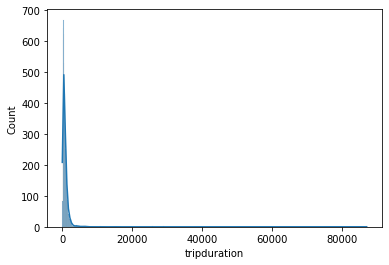

In [ ]:
#checking outliers and distribution of trip duration
sns.histplot(data=bluebikes, x="tripduration",kde=True)

In [ ]:
#I will drop trips longer than 60 minutes, total 118 rows.
len(bluebikes[bluebikes['tripduration'] > 3600])

118

## Processing Data
* Drop outliers
* Convert birthyear to age
* Parse starttime
* Get dummy variables
* Drop unnecessary columns

In [ ]:

def processData(data):
    Data = data
    # dropping outliers
    Data.drop(Data[Data['tripduration'] > 3600].index, inplace = True)
    # converting birthyear to age
    Data['age'] = 2022 - Data['birth year']
    # process starttime to min and sec
    Data[['start_min','start_sec']] = Data.starttime.str.split(pat=':',expand=True)
    Data['start_min'] = pd.to_numeric(Data['start_min'])
    Data['start_sec'] = pd.to_numeric(Data['start_sec'])
    # dropping unnecessary columns
    Data.drop(columns=['birth year','start station name', 'end station name', 'bikeid'], axis=1, inplace=True)
    Data.drop(['starttime', 'stoptime'], axis=1, inplace=True)
    # getting dummy variables for usertype
    Data = pd.get_dummies(Data, columns=['usertype'], drop_first=True)

    # Make sure you send back a pair of numpy arrays that can then feed into your NN model.
    predictors = Data.drop(columns=['tripduration'], axis=1)
    labels = Data['tripduration']

    return predictors, labels


#*Specify Neural Network Architecture, Process Your Sample*

## Calling the data pre-processing function on the dataset.

In [ ]:
predictors, labels = processData(bluebikes)

In [ ]:
from sklearn.model_selection import train_test_split

## Train test split

In [ ]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(predictors, labels, test_size=0.2, random_state=865)

In [ ]:
# import tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Building Neural Network Model
* Model loss : MAE
* Optimizer : Adam
* 3 hidden layers


In [ ]:
def build_model():
    model = keras.Sequential([
        layers.BatchNormalization(),
        layers.Dense(64, activation="relu",kernel_regularizer="l2"),
        layers.BatchNormalization(),
        layers.Dropout(0.1),
        layers.Dense(32, activation="selu"),
        layers.BatchNormalization(),
        layers.Dense(16, activation="relu"),
        layers.Dense(8, activation="selu"),
        layers.Dense(1, activation="linear")
    ])

    model.compile(optimizer="adam", loss="mae", metrics=["mae"])
    return model


## Cross Validation

In [ ]:
#Cross- Validation by 5 folds
k = 5
num_val_samples = len(X_train) // k 
num_epochs = 150
all_loss_history = []
all_val_loss_history = []

print("In total, we have",len(X_train),"training observations.")
print("With a k of",k,"we have",num_val_samples,"observations per fold.\n")

for i in range(k): 
    print("Processing fold #:",i)
 
    print("Validation data includes observations",i*num_val_samples,"through",(i+1)*num_val_samples-1) 
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    print("Training data includes observations 0 through",i*num_val_samples-1,"joined with observations",(i+1)*num_val_samples,"through the final observation.\n")
    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=128, verbose=1)
    val_loss_history = history.history['val_loss']
    loss_history = history.history['loss']
    all_val_loss_history.append(val_loss_history)
    all_loss_history.append(loss_history)

In total, we have 7105 training observations.
With a k of 5 we have 1421 observations per fold.

Processing fold #: 0
Validation data includes observations 0 through 1420
Training data includes observations 0 through -1 joined with observations 1421 through the final observation.

Epoch 1/150
45/45 [==============================] - 2s 12ms/step - loss: 752.8421 - mae: 752.6581 - val_loss: 752.1848 - val_mae: 752.0051
Epoch 2/150
45/45 [==============================] - 0s 3ms/step - loss: 743.8387 - mae: 743.6642 - val_loss: 709.2703 - val_mae: 709.1010
Epoch 3/150
45/45 [==============================] - 0s 3ms/step - loss: 721.9767 - mae: 721.8127 - val_loss: 636.5574 - val_mae: 636.3991
Epoch 4/150
45/45 [==============================] - 0s 3ms/step - loss: 671.5095 - mae: 671.3548 - val_loss: 549.0931 - val_mae: 548.9416
Epoch 5/150
45/45 [==============================] - 0s 3ms/step - loss: 586.4895 - mae: 586.3399 - val_loss: 485.6819 - val_mae: 485.5341
Epoch 6/150
45/45 [===

In [ ]:
average_loss_history = [np.mean([x[i] for x in all_loss_history]) for i in range(num_epochs)]
len(average_loss_history)

150

In [ ]:
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_history]) for i in range(num_epochs)]
len(average_val_loss_history)

150

## Plot model loss
* Plot of average training loss and average validatoin loss across 5 folds.
* I can see validation loss is flatenning after 100. Therefore, I will choose 100 epochs for the final model.

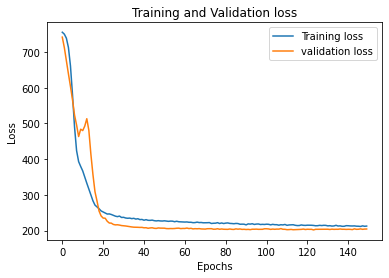

In [ ]:
# plot of average training loss and average validatoin loss across 5 folds
import matplotlib.pyplot as plt

plt.plot(average_loss_history[:], label="Training loss")
plt.plot(average_val_loss_history[:], label="validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#*Once You Choose the Final Configuration, Output that Model Here*

In [ ]:
# final model
model = build_model()
model.fit(X_train, y_train,
          epochs=100, batch_size=128, verbose=1)
model_evaluation = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/100
56/56 [==============================] - 1s 2ms/step - loss: 755.0975 - mae: 754.9078
Epoch 2/100
56/56 [==============================] - 0s 2ms/step - loss: 748.5854 - mae: 748.4164
Epoch 3/100
56/56 [==============================] - 0s 3ms/step - loss: 727.5020 - mae: 727.3558
Epoch 4/100
56/56 [==============================] - 0s 3ms/step - loss: 663.6381 - mae: 663.5061
Epoch 5/100
56/56 [==============================] - 0s 2ms/step - loss: 548.6181 - mae: 548.4933
Epoch 6/100
56/56 [==============================] - 0s 3ms/step - loss: 441.5116 - mae: 441.3926
Epoch 7/100
56/56 [==============================] - 0s 3ms/step - loss: 394.9410 - mae: 394.8218
Epoch 8/100
56/56 [==============================] - 0s 3ms/step - loss: 367.4813 - mae: 367.3602
Epoch 9/100
56/56 [==============================] - 0s 3ms/step - loss: 341.8980 - mae: 341.7745
Epoch 10/100
56/56 [==============================] - 0s 2ms/step - loss: 326.5824 - mae: 326.4544
Epoch 11/100
56/56 

In [ ]:
# Model evaluation
print(model_evaluation)

[220.269287109375, 220.10293579101562]


In [ ]:
predictions = model.predict(X_test)

Take a look at your model's final structure:

In [ ]:
# Model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_18 (Bat  (None, 11)               44        
 chNormalization)                                                
                                                                 
 dense_30 (Dense)            (None, 64)                768       
                                                                 
 batch_normalization_19 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_31 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_20 (Bat  (None, 32)              

In [ ]:
from google.colab import files
import io
import pandas as pd

# I am going to upload my holdout dataset and pass it to your final model. This data will have the exact same set of columns as the data I gave you to fit your model to.
uploaded = files.upload()
bluebike_holdout = pd.read_csv(io.BytesIO(uploaded['bluebikes_holdout.csv']))

# I'm then going to pre-process it using your data processing function.
holdout_predictors, holdout_labels = processData(bluebike_holdout)

# Then, I'm going to request your model's prediction performance. 
# I expect you should be able to predict trip durations within at least 1000 seconds of ground truth, on average (at worst).
loss_metrics = model.evaluate(holdout_predictors,holdout_labels,verbose=1)